In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# VAE Architecture
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [3]:
# Training function
def train_vae(model, train_loader, optimizer, device, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            data = data.view(-1, 784)
            optimizer.zero_grad()
            
            recon_batch, mu, log_var = model(data)
            
            # Reconstruction loss
            recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')
            
            # KL divergence
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            # Total loss
            loss = recon_loss + kl_loss
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
            
        avg_loss = total_loss / len(train_loader.dataset)
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

In [4]:
# Get latent representations and create visualization
def visualize_latent_space(model, test_loader, device):
    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            data = data.view(-1, 784)
            mu, _ = model.encode(data)
            latent_vectors.append(mu.cpu().numpy())
            labels.extend(target.numpy())
    
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.array(labels)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], 
                         c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('VAE Latent Space Visualization of MNIST Digits')
    plt.show()


Epoch [5/20], Average Loss: 148.1619
Epoch [10/20], Average Loss: 143.1611
Epoch [15/20], Average Loss: 140.6955
Epoch [20/20], Average Loss: 139.3730


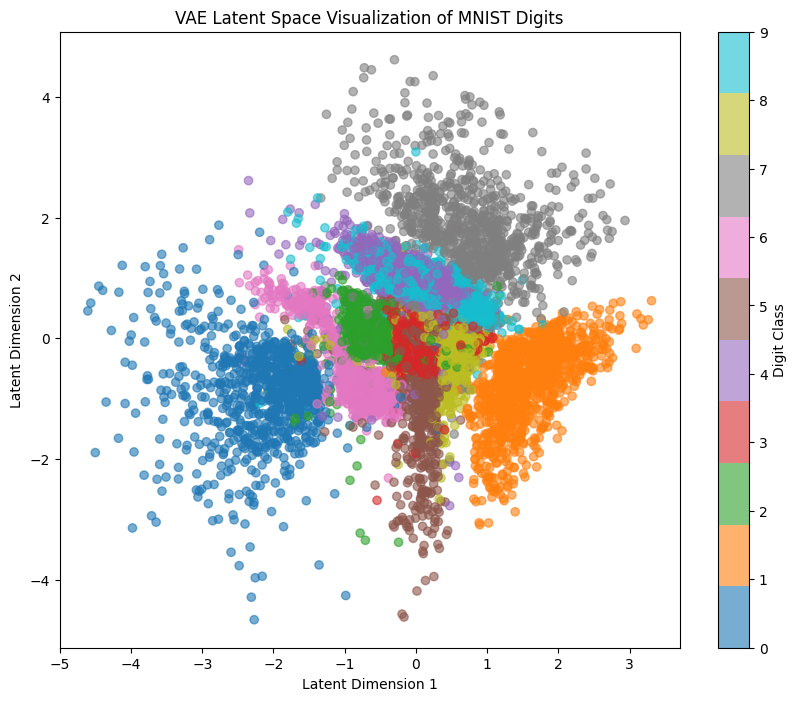

In [5]:

# Main execution
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Initialize model, optimizer
    model = VAE(latent_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Train model
    train_vae(model, train_loader, optimizer, device)
    
    # Visualize latent space
    visualize_latent_space(model, test_loader, device)

if __name__ == '__main__':
    main()